### Программа А

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%%bash
pip install pycuda

In [3]:
import pycuda.driver as drv
drv.init()
print(f'Number of GPU Devices Detected: {drv.Device.count()}')

Number of GPU Devices Detected: 1


In [4]:
gpu_device = drv.Device(0)
print(f'GPU Device name: {gpu_device.name()}')
print(f'GPU Device Compute Capability: {gpu_device.compute_capability()}')
print(f'GPU Global Memory Size = {gpu_device.total_memory()//1024**2} Mbytes')

GPU Device name: Tesla T4
GPU Device Compute Capability: (7, 5)
GPU Global Memory Size = 15101 Mbytes


In [5]:
device_attributes_keys = gpu_device.get_attributes().keys()
device_attributes_values = gpu_device.get_attributes().values()
count = len(list(device_attributes_keys))
device_attributes_keys = list(device_attributes_keys)
device_attributes_values = list(device_attributes_values)

device_attributes = {}
for i in range(count):
  device_attributes[str(device_attributes_keys[i])] = device_attributes_values[i]

In [6]:
print('GPU Device Technical Specification:')
for i in device_attributes.keys():
  print(f'{i} : {device_attributes[i]}')

GPU Device Technical Specification:
ASYNC_ENGINE_COUNT : 3
CAN_MAP_HOST_MEMORY : 1
CAN_USE_HOST_POINTER_FOR_REGISTERED_MEM : 1
CLOCK_RATE : 1590000
COMPUTE_CAPABILITY_MAJOR : 7
COMPUTE_CAPABILITY_MINOR : 5
COMPUTE_MODE : DEFAULT
COMPUTE_PREEMPTION_SUPPORTED : 1
CONCURRENT_KERNELS : 1
CONCURRENT_MANAGED_ACCESS : 1
DIRECT_MANAGED_MEM_ACCESS_FROM_HOST : 0
ECC_ENABLED : 1
GENERIC_COMPRESSION_SUPPORTED : 0
GLOBAL_L1_CACHE_SUPPORTED : 1
GLOBAL_MEMORY_BUS_WIDTH : 256
GPU_OVERLAP : 1
HANDLE_TYPE_POSIX_FILE_DESCRIPTOR_SUPPORTED : 1
HANDLE_TYPE_WIN32_HANDLE_SUPPORTED : 0
HANDLE_TYPE_WIN32_KMT_HANDLE_SUPPORTED : 0
HOST_NATIVE_ATOMIC_SUPPORTED : 0
INTEGRATED : 0
KERNEL_EXEC_TIMEOUT : 0
L2_CACHE_SIZE : 4194304
LOCAL_L1_CACHE_SUPPORTED : 1
MANAGED_MEMORY : 1
MAXIMUM_SURFACE1D_LAYERED_LAYERS : 2048
MAXIMUM_SURFACE1D_LAYERED_WIDTH : 32768
MAXIMUM_SURFACE1D_WIDTH : 32768
MAXIMUM_SURFACE2D_HEIGHT : 65536
MAXIMUM_SURFACE2D_LAYERED_HEIGHT : 32768
MAXIMUM_SURFACE2D_LAYERED_LAYERS : 2048
MAXIMUM_SURFACE2D_L

In [ ]:
import numpy as np
import time
import pycuda.autoinit
from pycuda import gpuarray
import cv2
import matplotlib.pyplot as plt

#### Тествое изображение с разрешением 768x1024

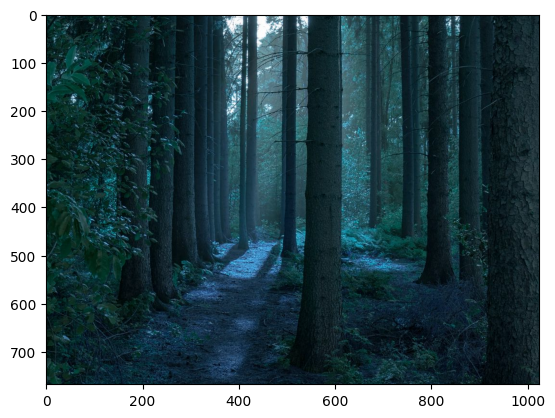

In [ ]:
image = cv2.imread('/content/gdrive/MyDrive/tropa_les_derevia_944568_1024x768.jpg')
plt.imshow(image)

#### Изображение с разрешением 10240x7680

In [ ]:
image = cv2.imread('/content/gdrive/MyDrive/tropa_les_derevia_10240x7680.jpg')
image.shape

(7680, 10240, 3)

#### Изображение с разрешением 12800x9600

In [ ]:
image = cv2.imread('/content/gdrive/MyDrive/цветок_лепестки_белый_12800_9600.jpg')
image.shape

(9600, 12800, 3)

#### Изображение с разрешением 20480x15360

In [ ]:
image = cv2.imread('/content/gdrive/MyDrive/калифорнии_штаты_Калифорния_20480 x 15360.jpg')
image.shape

(15360, 20480, 3)

#### Программа обработки изображения на PyCUDA

In [ ]:
print(type(image[0,0,0]))

<class 'numpy.uint8'>


In [ ]:
print(f'File Sizes = {image.shape}')
image_height = image.shape[0]
print(f'Image Height = {image_height}')
image_width = image.shape[1]
print(f'Image Width = {image_width}')
num_of_channels = image.shape[2]
print(f'Number of Channels = {num_of_channels}')
num_of_pixels = image_height * image_width
print(f'Number of Pixels = {num_of_pixels}')
image_size = image_height * image_width * num_of_channels
print(f'Image Size = {image_size} uint8')


File Sizes = (768, 1024, 3)
Image Height = 768
Image Width = 1024
Number of Channels = 3
Number of Pixels = 786432
Image Size = 2359296 uint8


In [ ]:
input_image = image.astype(np.int32)
input_image = input_image.reshape(image_size)
print(type(input_image[0]))

<class 'numpy.int32'>


In [ ]:
# Компиляция ядра
from pycuda.compiler import SourceModule
grey_scale_plus_binarization_kernel = SourceModule("""
__global__ void grey_scale_plus_binarization_kernel(int *input, int *output, int image_height, int image_width, int treshold)
{
  int x = blockDim.x * blockIdx.x + threadIdx.x;
  int y = blockDim.y * blockIdx.y + threadIdx.y;

  if (x<image_width)
    if (y<image_height)
    {
      int i = y * image_width + x;
      int r = input[3*i];
      int g = input[3*i + 1];
      int b = input[3*i + 2];
      int gray_pixel = (r + g + b)/3;

      if (gray_pixel > treshold)
      {
        output[3*i] = 255;
        output[3*i+1] = 255;
        output[3*i+2] = 255;
      }
      else
      {
        output[3*i] = 0;
        output[3*i+1] = 0;
        output[3*i+2] = 0;
      }



    }
}""")
grey_scale_plus_binarization_kernel = grey_scale_plus_binarization_kernel.get_function('grey_scale_plus_binarization_kernel')

In [ ]:
block_2D_size_x = 32
block_2D_size_y = 32
block_2D_size_z = 1

grid_2D_size_x = round(image_width/block_2D_size_x) + 1
grid_2D_size_y = round(image_height/block_2D_size_y) + 1
grid_2D_size_z = 1
print(f'Block size = ({block_2D_size_x}, {block_2D_size_y}, {block_2D_size_z}) Threads')
print(f'Grid size = ({grid_2D_size_x}, {grid_2D_size_y}, {grid_2D_size_z}) Blocks')

Block size = (32, 32, 1) Threads
Grid size = (33, 25, 1) Blocks


In [ ]:
# Выделение памяти на GPU
device_input_image = gpuarray.to_gpu(input_image)
device_output_image = gpuarray.empty_like(device_input_image)

In [ ]:
# Выполнение ядра
grey_scale_plus_binarization_kernel(device_input_image, device_output_image,
                            np.int32(image_height),np.int32(image_width), np.int32(42),
                            block = (block_2D_size_x, block_2D_size_y, block_2D_size_z),
                            grid = (grid_2D_size_x, grid_2D_size_y, grid_2D_size_z))

# Получение ссылки на функцию ядра
host_output_image = device_output_image.get()

In [ ]:
host_output_image = host_output_image.astype(np.uint8)
host_output_image = host_output_image.reshape(image.shape)

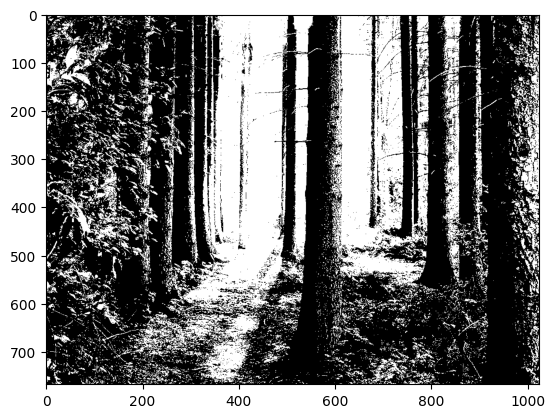

In [ ]:
plt.imshow(host_output_image[:,:,0],cmap = 'gray')

In [ ]:
# Дилатация делается на одноканальном изображении
binarized_image = host_output_image[:,:,0]

In [ ]:
# Компиляция ядра
dilate_kernel = SourceModule("""
__global__ void dilate_kernel(unsigned char *input, unsigned char *output, int image_height, int image_width, int kernel_size)
{
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    if (x >= image_width || y >= image_height)
    {
        return;  // гарантируем, чтобы потоки находятся внутри границ изображения
    }

    int radius = kernel_size / 2;
    unsigned char max_value = 0;

    for (int i = -radius; i <= radius; i++)
    {
        for (int j = -radius; j <= radius; j++)
         {
            int pixel_x = min(max(x + i, 0), image_width - 1);
            int pixel_y = min(max(y + j, 0), image_height - 1);

            int index = pixel_y * image_width + pixel_x;
            unsigned char pixel = input[index];

            if (pixel > max_value)
            {
                max_value = pixel;
            }
         }
    }

    int output_index = y * image_width + x;
    output[output_index] = max_value;
}
""")
dilate_kernel = dilate_kernel.get_function('dilate_kernel')

In [ ]:
# block_2D_size_x = 32
# block_2D_size_y = 32
# block_2D_size_z = 1

# grid_2D_size_x = round(width/block_2D_size_x) + 1
# grid_2D_size_y = round(height/block_2D_size_y) + 1
# grid_2D_size_z = 1

# print(f'Block size = ({block_2D_size_x}, {block_2D_size_y}, {block_2D_size_z}) Threads')
# print(f'Grid size = ({grid_2D_size_x}, {grid_2D_size_y}, {grid_2D_size_z}) Blocks')

In [ ]:
# Выделение памяти на GPU
device_input_image = gpuarray.to_gpu(binarized_image)
device_output_image = gpuarray.empty_like(device_input_image)

/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  globals().clear()


In [ ]:
# Выполнение ядра
dilate_kernel(device_input_image, device_output_image, np.int32(image_height), np.int32(image_width), np.int32(3),
              block = (block_2D_size_x, block_2D_size_y, block_2D_size_z),
              grid = (grid_2D_size_x, grid_2D_size_y, grid_2D_size_z))

# Получение ссылки на функцию ядра
dilated_image = device_output_image.get()

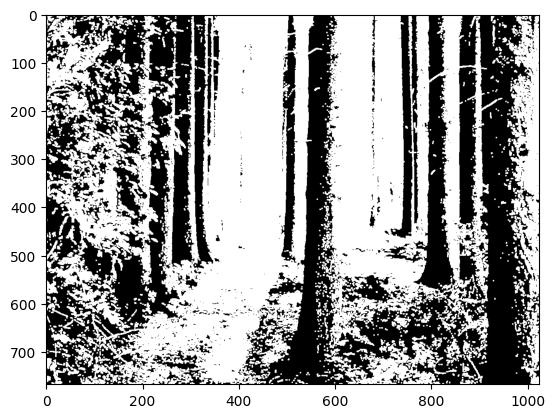

In [ ]:
plt.imshow(dilated_image,cmap = 'gray')

#### Тестирование

In [ ]:
elapsed_time = []
for _ in range(3):

  image_height = image.shape[0]
  image_width = image.shape[1]
  num_of_channels = image.shape[2]
  image_size = image_height * image_width * num_of_channels

  input_image = image.astype(np.int32)
  input_image = input_image.reshape(image_size)

  device_input_image = gpuarray.to_gpu(input_image)
  device_output_image = gpuarray.empty_like(device_input_image)

  block_2D_size_x = 32
  block_2D_size_y = 32
  block_2D_size_z = 1

  grid_2D_size_x = round(image_width/block_2D_size_x) + 1
  grid_2D_size_y = round(image_height/block_2D_size_y) + 1
  grid_2D_size_z = 1

  start_time = time.time()

  grey_scale_plus_binarization_kernel(device_input_image, device_output_image,
                            np.int32(image_height),np.int32(image_width), np.int32(42),
                            block = (block_2D_size_x, block_2D_size_y, block_2D_size_z),
                            grid = (grid_2D_size_x, grid_2D_size_y, grid_2D_size_z))

  host_output_image = device_output_image.get()
  host_output_image = host_output_image.astype(np.uint8)
  host_output_image = host_output_image.reshape(image.shape)

  binarized_image = host_output_image[:,:,0]

  device_input_image = gpuarray.to_gpu(binarized_image)
  device_output_image = gpuarray.empty_like(device_input_image)

  dilate_kernel(device_input_image, device_output_image, np.int32(image_height), np.int32(image_width), np.int32(3),
              block = (block_2D_size_x, block_2D_size_y, block_2D_size_z),
              grid = (grid_2D_size_x, grid_2D_size_y, grid_2D_size_z))

  dilated_image = device_output_image.get()

  elapsed_time.append(time.time() - start_time)

print(f'Среднее время обработки изображения {np.mean(elapsed_time)} секунд')

Среднее время обработки изображения 0.04013681411743164 секунд
